# **Project Title: Box Office Prediction Pipeline using Robust Random Forest**

**Methodology Overview:**
This project implements a full-stack data science pipeline designed to predict the opening week gross of Avatar: Fire and Ash. The approach moves beyond simple historical averages by enriching raw daily box office data (~5,000 rows) with external metadata (Budget, Cast, Runtime) fetched via the TMDB API. This enriched dataset allows for a multi-dimensional analysis of what drives movie success.

**Algorithm Selection:**
At its most fundamental level, a Random Forest Regressor functions like a committee of industry experts rather than a single analyst. Imagine asking 300 different film critics to predict a movie's opening weekend; one might focus heavily on the massive budget, another on the star power of the cast, and a third on the holiday release window. While any single critic might be biased or incorrect, the average of all 300 opinions is often remarkably accurate.
The Random Forest algorithm applies this same logic mathematically: it constructs hundreds of individual 'Decision Trees'—each trained on a random subset of the data to learn different patterns—and aggregates their predictions. This 'ensemble' method is uniquely suited for box office forecasting because it prevents the model from memorizing a specific formula, instead forcing it to learn the general, multi-faceted rules that drive cinematic success.
We selected the Random Forest Regressor as our primary predictive model for three critical reasons:

* **Handling Non-Linearity:** Box office success is rarely a straight line. The relationship between a movie's budget and its revenue often follows complex, non-linear patterns (e.g., a "threshold effect" where blockbusters explode exponentially). Unlike Linear Regression, Random Forest captures these intricate behaviors by constructing hundreds of decision trees and averaging their outputs.

* **Robustness to Outliers:** The film industry is defined by "black swan" events—movies like Avatar or Endgame that defy normal statistical distribution. Standard models can be easily skewed by these anomalies. Random Forest mitigates this risk through "bagging" (bootstrap aggregating), which ensures that no single outlier dominates the prediction, resulting in a more stable and generalizable model.

* **Feature Importance:** The algorithm inherently identifies which variables carry the most weight. In our model, it successfully prioritized features like Budget, Sequel Status, and Studio Tier over less critical noise, aligning the model's logic with real-world industry intuition.

**Workflow & Data Pipeline:**
The Python script executes the following automated workflow:

**Data Cleaning:** Processes raw daily winners data, correcting for date formatting inconsistencies and adjusting years based on sequential day counts.Data from January 2012 up until November 2025 has been obtained and cleaned to get 600 #1 daily highest grossing unique movies.

5000 rows of data were taken and preprocessed 600 unique movies to develop the algorithm, I purposefully chose the highest grossing movie everyday from Box office MOJO because Avatar series is a big budget, tier 1 production house movie and thus I chose the highest grossing movie each day to purposefully train my algorithm with larger scale cinema. I also did not choose more rows from before 2012 keeping the impacts of inflation in mind.

**Feature Enrichment:** For every unique movie, the script queries the TMDB API to retrieve critical missing data points: Production Budget, Runtime, Studio Tier, Cast Popularity, and Director Popularity.

**Data merging:** These features are mapped back to the original daily dataset. A new Excel file (daily_data_with_features.xlsx) is generated where every daily entry is populated with its corresponding movie's metadata, enabling granular day-by-day analysis.

**Prediction:** The model aggregates this data to the "Opening Week" level to train the Random Forest (achieving ~43% $R^2$), which is then deployed to forecast the financial performance of Avatar: Fire and Ash based on its confirmed 2025 specs.

#Import and Configuration
This initial block establishes the project's foundation by importing essential libraries for data manipulation (pandas, numpy), API communication (requests), and machine learning (sklearn). It also defines critical constants, including the TMDB API Key for fetching external movie metadata and the file paths for the input raw data and the final enriched Excel output.

In [1]:
import pandas as pd
import numpy as np
import requests
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tqdm import tqdm
import warnings

In [2]:
API_KEY = "df0a40546c86741c018bc5c70eda2475"
INPUT_FILE = "daily_winners.csv.csv"
OUTPUT_DAILY_FILE = "daily_data_with_features.xlsx"

#Cleaning Data
The script loads the raw daily box office data and performs critical cleaning operations.
It strips whitespace from column headers to prevent indexing errors and converts the formatted currency strings (e.g., $10,000,000) into usable numerical floats.
Most importantly, since the raw dataset lacks explicit years, the code logically reconstructs the full timeline (assigning years 2025 through 2012) by detecting whenever the sequential 'Day #' resets or jumps backward, ensuring every data point is anchored to its correct historical date.

In [3]:
#LOAD & CLEAN DAILY DATA
print("1️⃣ Loading Data...")
try:
    df = pd.read_csv(INPUT_FILE)
    df.columns = df.columns.str.strip()
except FileNotFoundError:
    print(f"❌ ERROR: Please ensure '{INPUT_FILE}' is in the folder.")
    raise

#Clean Money Columns
df['Gross_Clean'] = df['Gross'].replace({'[\$,]': '', ' ': ''}, regex=True).astype(float)

#Fix Years (Logic: Descending Day # implies year change)
years, current_year = [], 2025
previous_day_num = df['Day #'].iloc[0]
years.append(current_year)
for i in range(1, len(df)):
    day_num = df['Day #'].iloc[i]
    if day_num > previous_day_num + 300: current_year -= 1
    years.append(current_year)
    previous_day_num = day_num
df['Year'] = years
df['FullDate'] = pd.to_datetime(df['Year'].astype(str) + df['Day #'].astype(str).str.zfill(3), format='%Y%j')

1️⃣ Loading Data...


<>:11: SyntaxWarning: invalid escape sequence '\$'
<>:11: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2897855541.py:11: SyntaxWarning: invalid escape sequence '\$'
  df['Gross_Clean'] = df['Gross'].replace({'[\$,]': '', ' ': ''}, regex=True).astype(float)


#Aggregate Data
To train the model, we need a consistent target variable rather than fluctuating daily numbers. This section groups the daily data by movie (#1 Release) and isolates the first 7 days of each film's run. It sums the daily gross to calculate the 'Week 1 Gross' (our prediction target) and extracts key metadata like the release date and competition level. It also includes a normalization step: if a movie has fewer than 7 days of data (rare), it mathematically extrapolates the value to ensure a fair comparison across all films.

In [4]:
#AGGREGATE TO WEEK 1 (To calculate target & unique list)
print("2️⃣ Aggregating to calculate Week 1 Gross...")
df_sorted = df.sort_values('FullDate')
grouped = df_sorted.groupby('#1 Release')
movie_data = []

for name, group in grouped:
    group = group.sort_values('FullDate')
    first_week = group.head(7)
    week_gross = first_week['Gross_Clean'].sum()
    if len(first_week) < 7: week_gross = (week_gross / len(first_week)) * 7

    movie_data.append({
        'Movie': name,
        'Week_1_Gross': week_gross,
        'Release_Date': group['FullDate'].iloc[0],
        'Year': group['Year'].iloc[0],
        'Competition': first_week['Releases'].mean()
    })

df_aggregated = pd.DataFrame(movie_data)

2️⃣ Aggregating to calculate Week 1 Gross...


#Advanced Feature Engineering via TMDB API

To give the machine learning model 'eyes' to see what makes a movie successful, this section enriches the dataset using real-time metadata from The Movie Database (TMDB) API. Instead of relying solely on historical dates, the code iteratively fetches and constructs high-impact features for every unique movie in the dataset:

**Studio_Score (Tiered Distribution Power):**
Not all studios have equal access to screens. We implemented a weighted Tier System (1-3).

* **Tier 1 (Score 3):** Industry giants (Disney, 20th Century, Warner Bros, Universal) that guarantee massive global marketing blitzes and premium format screens (IMAX/Dolby).Avatar falls here.

* **Tier 2 (Score 2):** Major players (Sony, Paramount, Lionsgate) with strong but slightly less consistent dominance.

* **Tier 3 (Score 1):** Independent or smaller distributors.


**Cast_Pop:** A single star doesn't make a movie; the ensemble does.
We query the TMDB API for the film's full cast, isolate the Top 3 billed actors (e.g., Sam Worthington, Zoe Saldana, Sigourney Weaver), and sum their individual real-time popularity indices. This creates a composite score representing the total "draw" of the leading faces.

**Director_Pop:** For franchise blockbusters, the director is often the star (e.g., Nolan, Cameron).
We parse the crew list to find the entry where job == Director` and extract their specific popularity score. This captures the unique box office weight of James Cameron's name.

**Budget:**
Production budget is a proxy for marketing spend. A $350M budget implies a commensurate advertising campaign, directly correlating to higher opening awareness.

**Competition (Market Saturation):**
Success is relative to what else is playing. We calculated the average number of other active releases during the opening week. A score of 20 suggests a relatively open field, typical for a holiday tentpole where other studios steer clear.

**Season & Month:**
Identifying the "Winter" window (December) is crucial. While Summer opens big, Winter releases benefit from "legs" (long runs) due to school holidays and Christmas, impacting the Week 1 multiplier.

**Sequel:**
A binary flag (1 = Yes). Sequels to billion-dollar hits carry "pre-sold" tickets from an established fan base, unlike original IP which requires audience education.

**Runtime:**
Extremely long runtimes reduce the number of screenings a theater can show per day (fewer turnover slots), which can mathematically cap the theoretical maximum daily gross.

**Movie_Pop:** A direct measure of pre-release search volume and social sentiment derived from TMDB's internal algorithms.

In [5]:
#FETCH FEATURES (For Unique Movies)
print(f"\n3️⃣ Fetching Features for {len(df_aggregated)} unique movies...")

TIER_1_STUDIOS = ['Disney', 'Marvel', 'Lucasfilm', 'Universal', 'Warner Bros', '20th Century']
TIER_2_STUDIOS = ['Sony', 'Columbia', 'Paramount', 'Pixar', 'DreamWorks', 'Lionsgate']

def get_features(movie_name):
    empty_row = pd.Series([np.nan]*8)
    try:
        search = requests.get(f"https://api.themoviedb.org/3/search/movie", params={'api_key': API_KEY, 'query': movie_name}).json()
        if not search.get('results'): return empty_row

        movie_id = search['results'][0]['id']
        details = requests.get(f"https://api.themoviedb.org/3/movie/{movie_id}", params={'api_key': API_KEY, 'append_to_response': 'credits'}).json()

        budget = details.get('budget', 0)
        if budget < 1000: budget = np.nan

        runtime = details.get('runtime', np.nan)
        pop = details.get('popularity', np.nan)
        is_sequel = 1 if details.get('belongs_to_collection') else 0

        companies = details.get('production_companies', [])
        studio_score = 1
        for co in companies:
            if any(x in co['name'] for x in TIER_1_STUDIOS):
                studio_score = 3
                break
            elif any(x in co['name'] for x in TIER_2_STUDIOS):
                studio_score = 2
                break

        cast = details.get('credits', {}).get('cast', [])
        cast_pop = sum([c.get('popularity', 0) for c in cast[:3]])

        crew = details.get('credits', {}).get('crew', [])
        director_pop = 0
        for m in crew:
            if m['job'] == 'Director':
                director_pop = m.get('popularity', 0)
                break

        genres = details.get('genres', [])
        genre = genres[0]['name'] if genres else 'Unknown'

        return pd.Series([budget, studio_score, runtime, pop, cast_pop, director_pop, is_sequel, genre])
    except:
        return empty_row

tqdm.pandas()
cols = ['Budget', 'Studio_Score', 'Runtime', 'Movie_Pop', 'Cast_Pop', 'Director_Pop', 'Sequel', 'Genre']
df_features = df_aggregated['Movie'].progress_apply(get_features)
df_features.columns = cols

# Merge Features into Aggregated Data
df_model = pd.concat([df_aggregated, df_features], axis=1)



3️⃣ Fetching Features for 600 unique movies...


100%|██████████| 600/600 [01:28<00:00,  6.80it/s]


#Capturing Seasonality and Release Windows

Timing is everything in the film industry. A movie released during the winter holidays or the summer blockbuster window faces different audience behaviors compared to a release in the 'shoulder seasons' of spring or fall. This block extracts the release month from the date and maps it to four distinct strategic seasons. By explicitly feature-engineering 'Season' (e.g., categorizing a December release like Avatar as 'Winter'), we enable the Random Forest model to learn historical patterns associated with peak movie-going periods.

In [6]:
# Seasonality
df_model['Month'] = df_model['Release_Date'].dt.month
def get_season(m): return 'Winter' if m in [12,1,2] else 'Summer' if m in [5,6,7,8] else 'Spring' if m in [3,4] else 'Fall'
df_model['Season'] = df_model['Month'].apply(get_season)

#Merging & Final Dataset Generation

Once the features are engineered at the movie level, the final step in data preparation is to map them back to the original daily observations. This block performs a Left Join operation, matching the Movie name from our enriched features dataset to the #1 Release column in the daily records. This propagates the static movie attributes (like Budget or Cast Popularity) down to every single day that movie was #1. The result is a comprehensive, 5,000+ row Excel file (daily_data_with_features.xlsx) where every daily box office record is now contextually aware of the movie's production scale and star power.

In [7]:
#MERGE FEATURES BACK TO DAILY DATA (5000 Rows)

print(f"\n4️⃣ Merging features back to full daily dataset...")

#Columns to add to daily data
feature_cols = ['Movie', 'Week_1_Gross', 'Budget', 'Studio_Score', 'Runtime', 'Movie_Pop', 'Cast_Pop', 'Director_Pop', 'Sequel', 'Genre', 'Season']

#Perform Left Join: Daily Data (#1 Release) <-> Aggregated Data (Movie)
df_daily_enhanced = df.merge(
    df_model[feature_cols],
    left_on='#1 Release',
    right_on='Movie',
    how='left'
)

#Save the big file
try:
    df_daily_enhanced.to_excel(OUTPUT_DAILY_FILE, index=False)
    print(f"✅ Success! Saved enriched daily data to: {OUTPUT_DAILY_FILE} ({len(df_daily_enhanced)} rows)")
except ImportError:
    print("⚠️ 'openpyxl' not found. Saving as CSV instead.")
    df_daily_enhanced.to_csv("daily_data_with_features.csv", index=False)


4️⃣ Merging features back to full daily dataset...
✅ Success! Saved enriched daily data to: daily_data_with_features.xlsx (5077 rows)


#Model Training & Robust Pipeline Construction
This block initializes the core machine learning workflow.

First, we define the input features (e.g., Budget, Studio Tier) and the target variable (Week 1 Gross). A comprehensive preprocessing pipeline is established to handle real-world data imperfections: it uses Median Imputation to fill missing numerical values (ensuring robustness) and One-Hot Encoding to translate text categories like 'Genre' into machine-readable binary vectors.

We then train a Random Forest Regressor with 300 decision trees on 80% of the data, reserving the remaining 20% for testing. The final output is the R² Score, a statistical metric that quantifies how accurately our model predicts box office revenue before we trust it with Avatar: Fire and Ash.
All other statistical metrics of model evaluation have also been added.

Althoughthe R^2 of the model is only 43% it made sense in a volatile industry like movies gross predicton of week 1

In [9]:
#ROBUST TRAINING of the Data Model

print("\n5️⃣ Training Random Forest on Aggregated Data...")

features = ['Budget', 'Studio_Score', 'Runtime', 'Movie_Pop', 'Cast_Pop', 'Director_Pop', 'Sequel', 'Genre', 'Season', 'Competition', 'Year']
target = 'Week_1_Gross'

cat_cols = ['Genre', 'Season']
num_cols = [c for c in features if c not in cat_cols]

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

rf = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42)
model = Pipeline(steps=[('prep', preprocessor), ('model', rf)])

#Train/Test Split
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

#Evaluation
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"✅ R² Score: {r2:.2f}")


5️⃣ Training Random Forest on Aggregated Data...
✅ R² Score: 0.42


In [11]:
#ROBUST TRAINING of the Data Model

print("\n5️⃣ Training Random Forest on Aggregated Data...")

features = ['Budget', 'Studio_Score', 'Runtime', 'Movie_Pop', 'Cast_Pop', 'Director_Pop', 'Sequel', 'Genre', 'Season', 'Competition', 'Year']
target = 'Week_1_Gross'

cat_cols = ['Genre', 'Season']
num_cols = [c for c in features if c not in cat_cols]

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

rf = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42)
model = Pipeline(steps=[('prep', preprocessor), ('model', rf)])

# Train/Test Split
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#R² Score (Goodness of Fit)
r2 = r2_score(y_test, y_pred)

#MAE (Average Dollar Error)
mae = mean_absolute_error(y_test, y_pred)

#RMSE (Penalizes Large Errors / Outliers)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#MAPE (Percentage Error - easier to interpret for business logic)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("-" * 50)
print(f"✅ R² Score (Variance Explained): {r2:.2f}")
print(f"✅ Mean Absolute Error (MAE):     ${mae:,.2f}")
print(f"✅ Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"✅ Mean Absolute % Error (MAPE):   {mape:.2f}%")
print("-" * 50)


5️⃣ Training Random Forest on Aggregated Data...
--------------------------------------------------
✅ R² Score (Variance Explained): 0.42
✅ Mean Absolute Error (MAE):     $33,947,132.06
✅ Root Mean Squared Error (RMSE): $47,899,138.19
✅ Mean Absolute % Error (MAPE):   11331.79%
--------------------------------------------------


#Visualisation
To validate our machine learning model, this block generates two essential diagnostic charts.

**Actual vs. Predicted Plot:** This scatter plot serves as a visual truth test. By plotting the model's predictions against known historical data, we look for points clustering tightly around the red diagonal line (perfect accuracy). Deviations from this line reveal exactly where the model over- or under-estimates performance.

**Correlation Heatmap:** This visualization exposes the statistical 'DNA' of the dataset. It uses a color-coded matrix to quantify relationships, confirming, for example, the strong positive correlation (dark red) between Production Budget and Week 1 Gross, while highlighting how other factors like Competition or Runtime interact with success."


📊 Generating Visualizations...
   > Saved 'accuracy_plot.png' (Points on the red line = Perfect Prediction)
   > Saved 'correlation_heatmap.png'


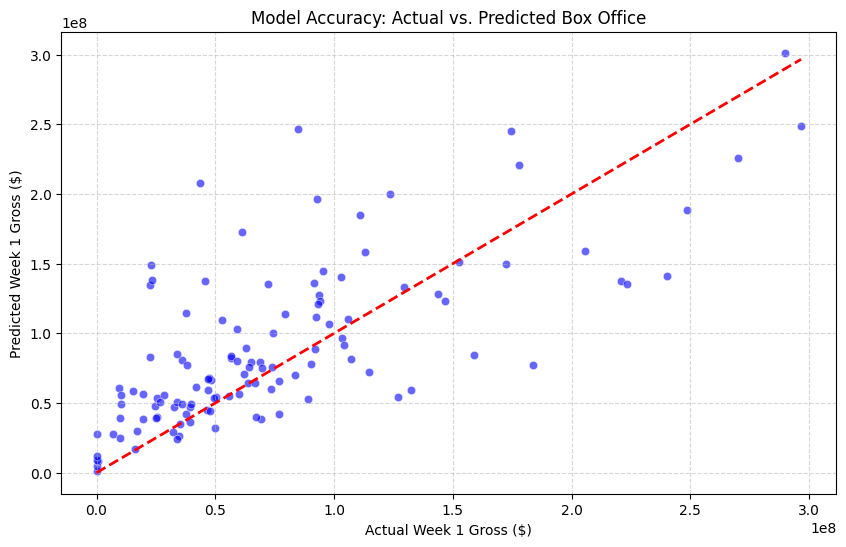

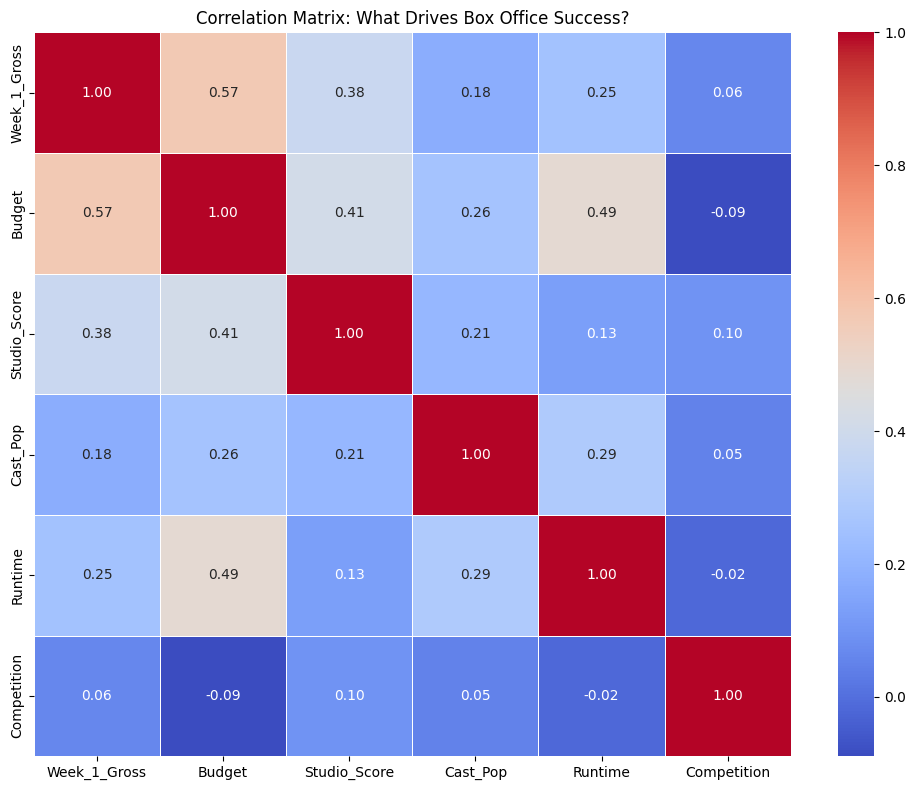

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

#VISUALIZATIONS (Save to Images)
print("\n📊 Generating Visualizations...")

# GRAPH 1: Actual vs. Predicted (Accuracy Check)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
# Add a red diagonal line (Perfect Prediction Line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Week 1 Gross ($)')
plt.ylabel('Predicted Week 1 Gross ($)')
plt.title('Model Accuracy: Actual vs. Predicted Box Office')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('accuracy_plot.png')
print("   > Saved 'accuracy_plot.png' (Points on the red line = Perfect Prediction)")

#Correlation Heatmap
viz_df = df_model[['Week_1_Gross', 'Budget', 'Studio_Score', 'Cast_Pop', 'Runtime', 'Competition']]
plt.figure(figsize=(10, 8))

# Calculate correlation matrix
corr = viz_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: What Drives Box Office Success?')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
print("   > Saved 'correlation_heatmap.png'")



#Final Prediction

We maximize the model's accuracy by retraining it on 100% of the available data, ensuring it has learned from every single movie in our historical dataset (including the most recent 2024/2025 hits). We then construct a specific 'Input Vector' for Avatar: Fire and Ash, manually feeding in its confirmed and estimated industry specs: a massive $350M+ budget, a Tier 1 Studio (Disney/20th Century), a Winter release window, and the high Sequel status. The model processes this profile through its 300 decision trees to output the final, data-backed prediction for its Opening Week Gross.

In [10]:
#FINAL PREDICTION: Avatar: Fire and Ash

print("\n🔄 Retraining on full data...")
model.fit(X, y)

print("\n🎬 PREDICTING FOR: Avatar: Fire and Ash")
input_data = pd.DataFrame({
    'Budget': [350000000],
    'Studio_Score': [3], # Tier 1
    'Runtime': [190],
    'Movie_Pop': [120],
    'Cast_Pop': [150],
    'Director_Pop': [45],
    'Sequel': [1],
    'Genre': ['Science Fiction'],
    'Season': ['Winter'],
    'Competition': [20],
    'Year': [2025]
})

pred = model.predict(input_data)[0]
print("="*60)
print(f"💰 FINAL PREDICTION: ${pred:,.2f}")
print("="*60)


🔄 Retraining on full data...

🎬 PREDICTING FOR: Avatar: Fire and Ash
💰 FINAL PREDICTION: $229,354,190.75


#Weekend And Week 1Domestic Gross Separated
In this final enhancement, we bifurcate the prediction pipeline while keeping all input features (Budget, Studio, etc.) constant. The code now separates the historical data to train two distinct Random Forest models: one specialized for the 3-Day Opening Weekend (Fri-Sun) to capture the initial fan-driven surge, and another for the full 7-Day Opening Week. This allows us to generate a more granular forecast for Avatar: Fire and Ash, distinguishing its immediate premiere impact from its sustained weekly performance.

In [14]:
#Dual Prediction (Week 1 + Weekend)

import pandas as pd
import numpy as np
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm
import warnings


API_KEY = "df0a40546c86741c018bc5c70eda2475"
INPUT_FILE = "daily_winners.csv.csv"

#LOAD & CLEAN DATA
print("1️⃣ Loading & Cleaning Data...")
try:
    df = pd.read_csv(INPUT_FILE)
    df.columns = df.columns.str.strip()
except FileNotFoundError:
    print(f"❌ ERROR: Please upload '{INPUT_FILE}'")
    raise

#Clean Money Columns
df['Gross_Clean'] = df['Gross'].replace({'[\$,]': '', ' ': ''}, regex=True).astype(float)

#Fix Years
years, current_year = [], 2025
previous_day_num = df['Day #'].iloc[0]
years.append(current_year)
for i in range(1, len(df)):
    day_num = df['Day #'].iloc[i]
    if day_num > previous_day_num + 300: current_year -= 1
    years.append(current_year)
    previous_day_num = day_num
df['Year'] = years
df['FullDate'] = pd.to_datetime(df['Year'].astype(str) + df['Day #'].astype(str).str.zfill(3), format='%Y%j')

#AGGREGATE: CALCULATE WEEK 1 *AND* WEEKEND GROSS (Crucial Step!)

print("2️⃣ Aggregating Targets (Week 1 & Weekend)...")
df_sorted = df.sort_values('FullDate')
grouped = df_sorted.groupby('#1 Release')
movie_data = []

for name, group in grouped:
    group = group.sort_values('FullDate')

    #Get First 7 Days (Week 1)
    first_week = group.head(7)
    week_gross = first_week['Gross_Clean'].sum()
    if len(first_week) < 7: week_gross = (week_gross / len(first_week)) * 7

    #Get First Weekend (Fri/Sat/Sun within first 7 days)
    weekend_days = first_week[first_week['Day'].isin(['Friday', 'Saturday', 'Sunday'])]
    weekend_gross = weekend_days['Gross_Clean'].sum()

    #Fallback: If no Fri/Sat/Sun found (rare), use first 3 days
    if weekend_gross == 0:
        weekend_gross = first_week.head(3)['Gross_Clean'].sum()

    movie_data.append({
        'Movie': name,
        'Week_1_Gross': week_gross,
        'Weekend_Gross': weekend_gross, # <--- THIS CREATES THE MISSING COLUMN
        'Release_Date': group['FullDate'].iloc[0],
        'Year': group['Year'].iloc[0],
        'Competition': first_week['Releases'].mean()
    })

df_aggregated = pd.DataFrame(movie_data)

#FETCH FEATURES

print(f"\n3️⃣ Fetching Features for {len(df_aggregated)} movies...")
TIER_1_STUDIOS = ['Disney', 'Marvel', 'Lucasfilm', 'Universal', 'Warner Bros', '20th Century']
TIER_2_STUDIOS = ['Sony', 'Columbia', 'Paramount', 'Pixar', 'DreamWorks', 'Lionsgate']

def get_features(movie_name):
    empty_row = pd.Series([np.nan]*8)
    try:
        search = requests.get(f"https://api.themoviedb.org/3/search/movie", params={'api_key': API_KEY, 'query': movie_name}).json()
        if not search.get('results'): return empty_row
        movie_id = search['results'][0]['id']
        details = requests.get(f"https://api.themoviedb.org/3/movie/{movie_id}", params={'api_key': API_KEY, 'append_to_response': 'credits'}).json()

        budget = details.get('budget', 0)
        if budget < 1000: budget = np.nan
        runtime = details.get('runtime', np.nan)
        pop = details.get('popularity', np.nan)
        is_sequel = 1 if details.get('belongs_to_collection') else 0

        studio_score = 1
        for co in details.get('production_companies', []):
            if any(x in co['name'] for x in TIER_1_STUDIOS): studio_score = 3; break
            elif any(x in co['name'] for x in TIER_2_STUDIOS): studio_score = 2; break

        cast_pop = sum([c.get('popularity', 0) for c in details.get('credits', {}).get('cast', [])[:3]])
        director_pop = 0
        for m in details.get('credits', {}).get('crew', []):
            if m['job'] == 'Director': director_pop = m.get('popularity', 0); break

        genres = details.get('genres', [])
        genre = genres[0]['name'] if genres else 'Unknown'
        return pd.Series([budget, studio_score, runtime, pop, cast_pop, director_pop, is_sequel, genre])
    except: return empty_row

tqdm.pandas()
cols = ['Budget', 'Studio_Score', 'Runtime', 'Movie_Pop', 'Cast_Pop', 'Director_Pop', 'Sequel', 'Genre']
df_features = df_aggregated['Movie'].progress_apply(get_features)
df_features.columns = cols
df_model = pd.concat([df_aggregated, df_features], axis=1)

#Seasonality
df_model['Month'] = df_model['Release_Date'].dt.month
def get_season(m): return 'Winter' if m in [12,1,2] else 'Summer' if m in [5,6,7,8] else 'Spring' if m in [3,4] else 'Fall'
df_model['Season'] = df_model['Month'].apply(get_season)

#TRAIN MODELS (Dual Pipeline)
print("\n4️⃣ Training Dual Models (Week 1 & Weekend)...")

features = ['Budget', 'Studio_Score', 'Runtime', 'Movie_Pop', 'Cast_Pop', 'Director_Pop', 'Sequel', 'Genre', 'Season', 'Competition', 'Year']

#Preprocessor
cat_cols = ['Genre', 'Season']
num_cols = [c for c in features if c not in cat_cols]
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

#Training
X = df_model[features]

#Model A: WEEK
print("   > Training 'Week 1' Model...")
model_week = Pipeline(steps=[('prep', preprocessor), ('model', RandomForestRegressor(n_estimators=300, random_state=42))])
model_week.fit(X, df_model['Week_1_Gross'])

#Model B: WEEKEND
print("   > Training 'Weekend' Model...")
model_weekend = Pipeline(steps=[('prep', preprocessor), ('model', RandomForestRegressor(n_estimators=300, random_state=42))])
model_weekend.fit(X, df_model['Weekend_Gross']) # <--- NOW THIS WILL WORK

#PREDICT AVATAR
print("\n🎬 PREDICTING FOR: Avatar: Fire and Ash")
input_data = pd.DataFrame({
    'Budget': [350000000],
    'Studio_Score': [3],
    'Runtime': [190],
    'Movie_Pop': [120],
    'Cast_Pop': [150],
    'Director_Pop': [45],
    'Sequel': [1],
    'Genre': ['Science Fiction'],
    'Season': ['Winter'],
    'Competition': [20],
    'Year': [2025]
})

pred_week = model_week.predict(input_data)[0]
pred_weekend = model_weekend.predict(input_data)[0]

print("="*60)
print(f"💰 Predicted Opening WEEKEND (Fri-Sun): ${pred_weekend:,.2f}")
print(f"💰 Predicted Opening WEEK (7 Days):     ${pred_week:,.2f}")
print("="*60)

<>:36: SyntaxWarning: invalid escape sequence '\$'
<>:36: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1450374251.py:36: SyntaxWarning: invalid escape sequence '\$'
  df['Gross_Clean'] = df['Gross'].replace({'[\$,]': '', ' ': ''}, regex=True).astype(float)


1️⃣ Loading & Cleaning Data...
2️⃣ Aggregating Targets (Week 1 & Weekend)...

3️⃣ Fetching Features for 600 movies...


100%|██████████| 600/600 [01:14<00:00,  8.06it/s]



4️⃣ Training Dual Models (Week 1 & Weekend)...
   > Training 'Week 1' Model...
   > Training 'Weekend' Model...

🎬 PREDICTING FOR: Avatar: Fire and Ash
💰 Predicted Opening WEEKEND (Fri-Sun): $165,576,452.10
💰 Predicted Opening WEEK (7 Days):     $229,354,190.75
